<a href="https://colab.research.google.com/github/mohammel-debug/hmm-pos-tagger/blob/main/Implement_an_HMM_PoS_tagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPLEMENTING AN HMM POS TAGGER</center>

# We can share our ideas here

TODO

- Same method. Try with the other dataset
- Combine datasets and train.
- Test with one and the other dataset. Combined.
- Plot the accuracies. Analyse.
- How to improve.
- Analyse the error per tag, and the reason. For each model.
- Check nltk for interesting methods.
- See if we can add more things from the unfinished chunking lab.
- Trigram HMM


Yo probaria todas las mejoras: UNK, laplace smoothing, convertir syn/ant, trigram hmm, ... Y luego entrenaria sobre los dos datasets para y evaluar para ver si ver más datos ayuda al modelo a generalizar más

# OUTLINE

1.   Datasets loading
2.   Data Parsing
3.   HMM Implementation
4.   Evaluation
5.   Model Improvements
6.   Analysis and Discussion
7.   Cnclusion

# 1. Datasets Loading

In [1]:
import nltk
nltk.download('universal_tagset')
!pip install conllu
# dataset 1: CHILDES
!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_English-CHILDES/master/en_childes-ud-train.conllu
!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_English-CHILDES/master/en_childes-ud-dev.conllu
!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_English-CHILDES/master/en_childes-ud-test.conllu


# dataset 2: Web Text (EWT)
# Download EWT dataset with exact filenames
!wget -O /content/en_ewt-ud-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu
!wget -O /content/en_ewt-ud-dev.conllu   https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu
!wget -O /content/en_ewt-ud-test.conllu  https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


--2025-11-27 09:20:30--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15029817 (14M) [text/plain]
Saving to: ‘/content/en_ewt-ud-train.conllu’

/content/en_ewt-ud- 100%[===================>]  14.33M  --.-KB/s    in 0.1s    

2025-11-27 09:20:31 (133 MB/s) - ‘/content/en_ewt-ud-train.conllu’ saved [15029817/15029817]

--2025-11-27 09:20:31--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connect

CHILDES Dataset

In [2]:
data_train_childes = open("/content/en_childes-ud-train.conllu", "r", encoding="utf-8").read()
data_dev_childes = open("/content/en_childes-ud-dev.conllu", "r", encoding="utf-8").read()
data_test_childes = open("/content/en_childes-ud-test.conllu", "r", encoding="utf-8").read()

print("There are {} sentences in the training set.".format(len(data_train_childes)))
print("There are {} sentences in the testing set.".format(len(data_test_childes)))
print("There are {} sentences in the development set.".format(len(data_dev_childes)))

There are 19558483 sentences in the training set.
There are 5194505 sentences in the testing set.
There are 2159081 sentences in the development set.


EWT Dataset

In [3]:
data_train_ewt = open("/content/en_ewt-ud-train.conllu", "r", encoding="utf-8").read()
data_dev_ewt = open("/content/en_ewt-ud-dev.conllu", "r", encoding="utf-8").read()
data_test_ewt = open("/content/en_ewt-ud-test.conllu", "r", encoding="utf-8").read()

print("There are {} sentences in the training set.".format(len(data_train_ewt)))
print("There are {} sentences in the testing set.".format(len(data_test_ewt)))
print("There are {} sentences in the development set.".format(len(data_dev_ewt)))

There are 15028897 sentences in the training set.
There are 1899745 sentences in the testing set.
There are 1897963 sentences in the development set.


In [4]:
print(data_train_childes[:500])
print("----------------------------------")
print(data_train_ewt[:500])

# sent_id = 0
# original_sent_id = 1754162
# s_24_sent_id = 14944
# child_name = Adam
# childes_toks = you won't cut your finger what
# corpus_name = Brown
# gold_annotation = False
# child_age = 41.95363354483665
# child_gender = male
# speaker_role = Investigator
# type = question
# text = You won 't cut your finger what?
1	You	you	PRON	PRP	_	4	nsubj	4:nsubj	_
2	won	will	AUX	VBD	_	4	aux	4:aux	_
3	't	not	PART	RB	_	4	advmod	4:advmod	_
4	cut	cut	VERB	VB	_	0	root	0:root	_
5	your	your	PRON	PRP$	_	6
----------------------------------
# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000
# sent_id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001
# newpar id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001
# text = Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border.
1	Al	Al	PROPN	NNP	Number=Sing	0	root	0:root	SpaceAfter=No
2	-	-	PUNCT	HYPH	_	3	pun

# 2. Data Parsing

In [5]:
def parse_data(file1):

  sentences = []
  pos_tags = []

  current_sent_tokens = []
  current_sent_tags = []

  lines = file1.strip().split('\n')

  for line in lines:
      line = line.strip()

      # Skip comments/metadata and empty lines
      if line.startswith("#") or not line:
          # If we have accumulated tokens for a sentence, save them now
          if current_sent_tokens:
              sentences.append(current_sent_tokens)
              pos_tags.append(current_sent_tags)
              current_sent_tokens = []
              current_sent_tags = []
          continue

      parts = line.split('\t')

      # Safety check: ensure line has enough columns
      if len(parts) < 4:
          continue

      # Skip multi-word ranges (e.g., "1-2") because the individual tokens follow
      if '-' in parts[0]:
          continue

      # Append Token (Column 1) and UPOS (Column 3)
      # Note: If you want the specific XPOS tag (e.g., PRP, VBD), change index 3 to 4
      current_sent_tokens.append(parts[1])
      current_sent_tags.append(parts[3])

  # Flush the final sentence if the file didn't end with a newline
  if current_sent_tokens:
      sentences.append(current_sent_tokens)
      pos_tags.append(current_sent_tags)

  # --- Output Results ---
  print(f"Total Sentences found: {len(sentences)}\n")
  return sentences, pos_tags


In [6]:
# CHILDES dataset
sentences_train_childes, pos_tags_train_childes = parse_data(data_train_childes)
sentences_dev_childes, pos_tags_dev_childes = parse_data(data_dev_childes)
sentences_test_childes, pos_tags_test_childes = parse_data(data_test_childes)

# EWT dataset
sentences_train_ewt, pos_tags_train_ewt = parse_data(data_train_ewt)
sentences_dev_ewt, pos_tags_dev_ewt = parse_data(data_dev_ewt)
sentences_test_ewt, pos_tags_test_ewt = parse_data(data_test_ewt)

Total Sentences found: 34732

Total Sentences found: 3860

Total Sentences found: 9591

Total Sentences found: 12544

Total Sentences found: 2001

Total Sentences found: 2077



In [7]:
tagged_sentences_train_childes = [list(zip(s, p)) for s, p in zip(sentences_train_childes, pos_tags_train_childes)]
tagged_sentences_test_childes = [list(zip(s, p)) for s, p in zip(sentences_test_childes, pos_tags_test_childes)]
tagged_sentences_dev_childes = [list(zip(s, p)) for s, p in zip(sentences_dev_childes, pos_tags_dev_childes)]

tagged_sentences_train_ewt = [list(zip(s, p)) for s, p in zip(sentences_train_ewt, pos_tags_train_ewt)]
tagged_sentences_test_ewt = [list(zip(s, p)) for s, p in zip(sentences_test_ewt, pos_tags_test_ewt)]
tagged_sentences_dev_ewt = [list(zip(s, p)) for s, p in zip(sentences_dev_ewt, pos_tags_dev_ewt)]

## The POS Tagset distribution for both CHILDES and EWT

Total number of tags for childes: 17
{'ADJ', 'NOUN', 'DET', 'PROPN', 'AUX', 'CCONJ', 'SYM', 'VERB', 'NUM', 'PART', 'X', 'ADP', 'INTJ', 'PRON', 'SCONJ', 'ADV', 'PUNCT'}
Total number of tags for ewt: 17
{'ADJ', 'NOUN', 'DET', 'PROPN', 'AUX', 'CCONJ', 'SYM', 'VERB', 'NUM', 'PART', 'X', 'ADP', 'INTJ', 'PRON', 'SCONJ', 'ADV', 'PUNCT'}


<Axes: xlabel='Samples', ylabel='Counts'>

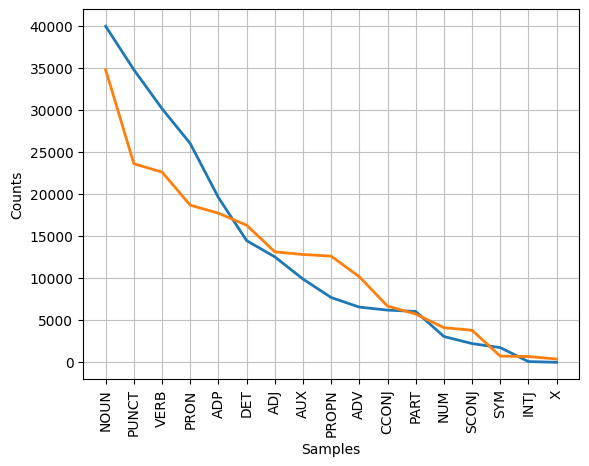

In [8]:
tags = set()
for word_l, tag_l in zip(sentences_train_childes, pos_tags_train_childes):
  for tag in tag_l:
    tags.add(tag)
# retrieve the total number of tags in the tagset and the set of tags
print(f"Total number of tags for childes: {len(tags)}")
print(tags)

tags = list()
for word, tag_l in zip(sentences_train_childes, pos_tags_train_childes):
  for tag in tag_l:
    tags.append(tag)
freq = nltk.FreqDist(tags)
freq.plot()

tags_ewt = set()
for word_l, tag_l in zip(sentences_train_ewt, pos_tags_train_ewt):
  for tag in tag_l:
    tags_ewt.add(tag)
# retrieve the total number of tags in the tagset and the set of tags
print(f"Total number of tags for ewt: {len(tags_ewt)}")
print(tags_ewt)

tags_ewt = list()
for word, tag_l in zip(sentences_train_ewt, pos_tags_train_ewt):
  for tag in tag_l:
    tags_ewt.append(tag)
freq = nltk.FreqDist(tags_ewt)
freq.plot()

# 3. HMM Implementation

In [9]:
from collections import defaultdict
import math

class HMM:
    def __init__(self, min_log_prob=-1e9):

        self.min_log_prob = min_log_prob

        self.transition = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.emission = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.start_prob = defaultdict(lambda: self.min_log_prob)

        self.tag_counts = defaultdict(int)
        self.states = []
        self.vocab = set()

    def _normalize_to_log(self, d):

        total = sum(d.values())
        if total == 0: return d

        log_total = math.log(total)

        new_d = defaultdict(lambda: self.min_log_prob)

        for k, count in d.items():
            new_d[k] = math.log(count) - log_total

        return new_d

    def train(self, train_data):


        temp_start = defaultdict(int)
        temp_trans = defaultdict(lambda: defaultdict(int))
        temp_emit = defaultdict(lambda: defaultdict(int))

        for sentence in train_data:
            prev_tag = None
            for i, (word, tag) in enumerate(sentence):
                self.vocab.add(word)
                self.tag_counts[tag] += 1
                temp_emit[tag][word] += 1

                if i == 0:
                    temp_start[tag] += 1
                else:
                    temp_trans[prev_tag][tag] += 1
                prev_tag = tag


        self.start_prob = self._normalize_to_log(temp_start)

        for tag in temp_emit:
            self.emission[tag] = self._normalize_to_log(temp_emit[tag])

        for prev in temp_trans:
            self.transition[prev] = self._normalize_to_log(temp_trans[prev])

        self.states = list(self.tag_counts.keys())

    def viterbi(self, sentence):
        V = [{}]
        path = {}

        for state in self.states:
            start_p = self.start_prob[state]
            emit_p = self.emission[state][sentence[0]]

            V[0][state] = start_p + emit_p
            path[state] = [state]

        for t in range(1, len(sentence)):
            V.append({})
            new_path = {}

            for curr_state in self.states:


                emit_p = self.emission[curr_state][sentence[t]]

                max_prob, prev_state = max(
                    (V[t - 1][y0] + self.transition[y0][curr_state] + emit_p, y0)
                    for y0 in self.states
                )

                V[t][curr_state] = max_prob
                new_path[curr_state] = path[prev_state] + [curr_state]

            path = new_path

        n = len(sentence) - 1
        if n < 0: return []

        prob, final_state = max((V[n][y], y) for y in self.states)
        return path[final_state]

    def evaluate(self, test_data):
        total_tags = 0
        correct_tags = 0

        for sentence in test_data:
            words = [pair[0] for pair in sentence]
            actual_tags = [pair[1] for pair in sentence]

            predicted_tags = self.viterbi(words)

            for pred, act in zip(predicted_tags, actual_tags):
                if pred == act:
                    correct_tags += 1
                total_tags += 1

        if total_tags == 0:
            return 0.0

        return correct_tags / total_tags

## Training and Evaluating the HMM on CHILDES Dataset

In [11]:
hmm_childes= HMM()
hmm_childes.train(tagged_sentences_train_childes)
print("CHILDES Dev Accuracy:", hmm_childes.evaluate(tagged_sentences_dev_childes))
print("CHILDES Test Accuracy:", hmm_childes.evaluate(tagged_sentences_test_childes))

CHILDES Dev Accuracy: 0.93944878650761
CHILDES Test Accuracy: 0.9087979094076655


## Training and Evaluating the HMM on EWT Dataset

In [12]:
hmm_ewt= HMM()
hmm_ewt.train(tagged_sentences_train_ewt)
print("EWT dev Accuracy:", hmm_ewt.evaluate(tagged_sentences_dev_ewt))
print("EWT Test Accuracy:", hmm_ewt.evaluate(tagged_sentences_test_ewt))

EWT dev Accuracy: 0.8837421971293388
EWT Test Accuracy: 0.8856789926681543


# 4. Evaluation

CHILDES Dev Accuracy: 0.936  VS. EWT dev Accuracy: 0.86

CHILDES Test Accuracy: 0.90  VS. EWT Test Accuracy: 0.865

This difference can be accounted for by the fact that the CHILDES dataset contains simple sentences and many words are repeated. In contrast, the EWT dataset is very diverse and can contain more larger and unknown words



We do some tests to see how the models perform:

In [13]:
test_s = "Hello, how are you doing today , Jorge ?".split()
print(hmm_childes.viterbi(test_s))
print(hmm_ewt.viterbi(test_s))

['PRON', 'ADV', 'AUX', 'PRON', 'VERB', 'NOUN', 'PUNCT', 'PUNCT', 'PUNCT']
['PRON', 'ADV', 'AUX', 'PRON', 'VERB', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT']


## Error Analysis

In [14]:
def calculate_error_rates(model, test_data):

    known_total = 0
    known_errors = 0
    unknown_total = 0
    unknown_errors = 0

    for sentence in test_data:
        words = [w for w, t in sentence]
        gold_tags = [t for w, t in sentence]

        try:
            pred_tags = model.viterbi(words)
        except:
            continue

        for word, pred, gold in zip(words, pred_tags, gold_tags):
            if word in model.vocab:
                known_total += 1
                if pred != gold:
                    known_errors += 1
            else:
                unknown_total += 1
                if pred != gold:
                    unknown_errors += 1

    known_error_rate = known_errors / known_total if known_total > 0 else 0
    unknown_error_rate = unknown_errors / unknown_total if unknown_total > 0 else 0

    total_ops = known_total + unknown_total
    total_errors = known_errors + unknown_errors
    total_error_rate = total_errors / total_ops if total_ops > 0 else 0

    return known_error_rate, unknown_error_rate, total_error_rate, known_errors, unknown_errors


k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_childes, tagged_sentences_test_childes)


k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_ewt, tagged_sentences_test_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (Rates & Volume)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)

DETAILED ERROR ANALYSIS (Rates & Volume)
CHILDES DATASET:
  - Known Word Error Rate:   6.34%  (Count: 3497)
  - Unknown Word Error Rate: 79.00%  (Count: 1738)
  - Total Error Rate:        9.12%
--------------------------------------------------
EWT DATASET:
  - Known Word Error Rate:   5.70%  (Count: 1299)
  - Unknown Word Error Rate: 68.50%  (Count: 1570)
  - Total Error Rate:        11.43%


We can see the error rate for unknown words is very big in both datasets, especially in childes, which may mean the model generalization is worse. Given this baseline we know should aim to reduce both known word errors and unknown word errors because both cause the model not to predict correctly

In [15]:
def find_and_print_unknowns(test_data, model, num_sentences):
    RED = "\033[91m"
    RESET = "\033[0m"

    found_count = 0

    for sentence in test_data:
        if found_count >= num_sentences:
            break

        words = [pair[0] for pair in sentence]
        actual_tags = [pair[1] for pair in sentence]

        has_unknown_word = any(word not in model.vocab for word in words)

        if has_unknown_word:
            predicted_tags = model.viterbi(words)

            formatted_words = []
            for word in words:
                if word not in model.vocab:
                    formatted_words.append(f"{RED}'{word}'{RESET}")
                else:
                    formatted_words.append(f"'{word}'")

            display_string = "[" + ", ".join(formatted_words) + "]"

            print(f"Sentence {found_count + 1} (Contains Unknowns):")
            print(f"Words:     {display_string}")
            print(f"Predicted: {predicted_tags}")
            print(f"Correct:   {actual_tags}")
            print("-" * 50)

            found_count += 1

    if found_count == 0:
        print("No sentences with unknown words were found.")


print("Childes")
find_and_print_unknowns(tagged_sentences_test_childes, hmm_childes, 2)
print("\n" + "="*40 + "\n")
print("EWT")
find_and_print_unknowns(tagged_sentences_test_ewt, hmm_ewt, 2)

Childes
Sentence 1 (Contains Unknowns):
Words:     ['Oh', 'that', 'was', 'a', 'nice', 'squeal', 'Thomas', '.']
Predicted: ['INTJ', 'PRON', 'AUX', 'DET', 'ADJ', 'NOUN', 'PROPN', 'PUNCT']
Correct:   ['INTJ', 'PRON', 'AUX', 'DET', 'ADJ', 'NOUN', 'PROPN', 'PUNCT']
--------------------------------------------------
Sentence 2 (Contains Unknowns):
Words:     ['Come', 'on', 'sweetheart', '.']
Predicted: ['VERB', 'ADP', 'PUNCT', 'PUNCT']
Correct:   ['VERB', 'ADV', 'NOUN', 'PUNCT']
--------------------------------------------------


EWT
Sentence 1 (Contains Unknowns):
Words:     ['What', 'if', 'Google', 'Morphed', 'Into', 'GoogleOS', '?']
Predicted: ['PRON', 'SCONJ', 'PROPN', 'NOUN', 'ADP', 'NOUN', 'PUNCT']
Correct:   ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']
--------------------------------------------------
Sentence 2 (Contains Unknowns):
Words:     ['What', 'if', 'Google', 'expanded', 'on', 'its', 'search', '-', 'engine', '(', 'and', 'now', 'e-mail', ')', 'wares', 'into', 

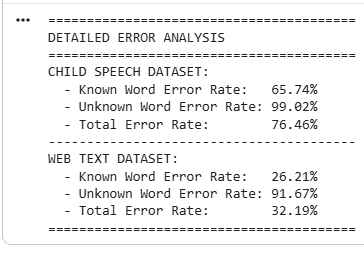

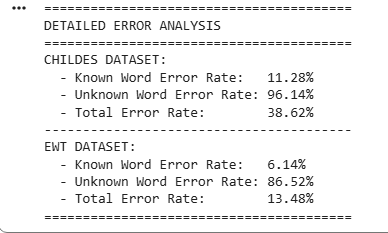

# 5. Model Improvements

## 5.1 Suffix-based Guessing??

## 5.2 Use "UNK" for Unkown Words??

We will define the new class

In [16]:
from collections import defaultdict
import math

class HMM_unk:
    def __init__(self, min_log_prob=-1e9):
        self.min_log_prob = min_log_prob
        self.transition = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.emission = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.start_prob = defaultdict(lambda: self.min_log_prob)
        self.tag_counts = defaultdict(int)
        self.states = []
        self.vocab = set()
        self.unk_token = "<UNK>"

    def _normalize_to_log(self, d):
        total = sum(d.values())
        if total == 0: return d
        log_total = math.log(total)
        new_d = defaultdict(lambda: self.min_log_prob)
        for k, count in d.items():
            new_d[k] = math.log(count) - log_total
        return new_d

    def train(self, train_data, freq_threshold=1):

        word_counts = defaultdict(int)
        for sentence in train_data:
            for word, tag in sentence:
                word_counts[word] += 1


        low_freq_words = {word for word, count in word_counts.items() if count <= freq_threshold}

        self.vocab.add(self.unk_token)

        temp_start = defaultdict(int)
        temp_trans = defaultdict(lambda: defaultdict(int))
        temp_emit = defaultdict(lambda: defaultdict(int))

        for sentence in train_data:
            prev_tag = None
            for i, (word, tag) in enumerate(sentence):

                if word in low_freq_words:
                    train_word = self.unk_token
                else:
                    train_word = word
                    self.vocab.add(train_word)

                self.tag_counts[tag] += 1
                temp_emit[tag][train_word] += 1

                if i == 0:
                    temp_start[tag] += 1
                else:
                    temp_trans[prev_tag][tag] += 1
                prev_tag = tag

        # Normalize
        self.start_prob = self._normalize_to_log(temp_start)
        for tag in temp_emit:
            self.emission[tag] = self._normalize_to_log(temp_emit[tag])
        for prev in temp_trans:
            self.transition[prev] = self._normalize_to_log(temp_trans[prev])

        self.states = list(self.tag_counts.keys())

    def viterbi(self, sentence):
        V = [{}]
        path = {}


        processed_sentence = []
        for word in sentence:
            if word in self.vocab:
                processed_sentence.append(word)
            else:
                processed_sentence.append(self.unk_token)

        for state in self.states:
            start_p = self.start_prob[state]
            emit_p = self.emission[state][processed_sentence[0]]

            V[0][state] = start_p + emit_p
            path[state] = [state]

        for t in range(1, len(processed_sentence)):
            V.append({})
            new_path = {}

            for curr_state in self.states:
                emit_p = self.emission[curr_state][processed_sentence[t]]

                max_prob, prev_state = max(
                    (V[t - 1][y0] + self.transition[y0][curr_state] + emit_p, y0)
                    for y0 in self.states
                )

                V[t][curr_state] = max_prob
                new_path[curr_state] = path[prev_state] + [curr_state]

            path = new_path

        n = len(sentence) - 1
        if n < 0: return []
        prob, final_state = max((V[n][y], y) for y in self.states)
        return path[final_state]

    def evaluate(self, test_data):
        total_tags = 0
        correct_tags = 0
        for sentence in test_data:
            words = [pair[0] for pair in sentence]
            actual_tags = [pair[1] for pair in sentence]
            predicted_tags = self.viterbi(words)
            for pred, act in zip(predicted_tags, actual_tags):
                if pred == act: correct_tags += 1
                total_tags += 1
        if total_tags == 0: return 0.0
        return correct_tags / total_tags

### Evaluation:

#### Training and Evaluating the HMM on CHILDES Dataset

In [17]:
hmm_childes_unk= HMM_unk()
hmm_childes_unk.train(tagged_sentences_train_childes)
print("CHILDES Dev Accuracy:", hmm_childes_unk.evaluate(tagged_sentences_dev_childes))
print("CHILDES Test Accuracy:", hmm_childes_unk.evaluate(tagged_sentences_test_childes))

CHILDES Dev Accuracy: 0.9390374331550803
CHILDES Test Accuracy: 0.9181184668989547


The test accuracy improves a

#### Training and Evaluating the HMM on EWT Dataset

In [18]:
hmm_ewt_unk= HMM_unk()
hmm_ewt_unk.train(tagged_sentences_train_ewt)
print("EWT dev Accuracy:", hmm_ewt_unk.evaluate(tagged_sentences_dev_ewt))
print("EWT Test Accuracy:", hmm_ewt_unk.evaluate(tagged_sentences_test_ewt))

EWT dev Accuracy: 0.8926881634925052
EWT Test Accuracy: 0.8948836467963022


#### Error Analysis

In [19]:
def calculate_error_rates(model, test_data):
    """
    Calculates specific error rates AND counts for known vs. unknown words.
    """
    known_total = 0
    known_errors = 0
    unknown_total = 0
    unknown_errors = 0

    for sentence in test_data:
        words = [w for w, t in sentence]
        gold_tags = [t for w, t in sentence]

        try:
            pred_tags = model.viterbi(words)
        except:
            continue

        for word, pred, gold in zip(words, pred_tags, gold_tags):
            if word in model.vocab:
                known_total += 1
                if pred != gold:
                    known_errors += 1
            else:
                unknown_total += 1
                if pred != gold:
                    unknown_errors += 1

    known_error_rate = known_errors / known_total if known_total > 0 else 0
    unknown_error_rate = unknown_errors / unknown_total if unknown_total > 0 else 0

    total_ops = known_total + unknown_total
    total_errors = known_errors + unknown_errors
    total_error_rate = total_errors / total_ops if total_ops > 0 else 0

    return known_error_rate, unknown_error_rate, total_error_rate, known_errors, unknown_errors


k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_childes_unk, tagged_sentences_test_childes)


k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_ewt_unk, tagged_sentences_test_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (Rates & Volume)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)

DETAILED ERROR ANALYSIS (Rates & Volume)
CHILDES DATASET:
  - Known Word Error Rate:   6.14%  (Count: 3351)
  - Unknown Word Error Rate: 47.48%  (Count: 1349)
  - Total Error Rate:        8.19%
--------------------------------------------------
EWT DATASET:
  - Known Word Error Rate:   5.39%  (Count: 1191)
  - Unknown Word Error Rate: 48.38%  (Count: 1447)
  - Total Error Rate:        10.51%


# 6. Analysis and Discussion

# 7. Summary/conclusion

# Info we might need :)

In [20]:
'''tags = set()
for word_l, tag_l in zip(sentences_train_childes, pos_tags_train_childes):
  for tag in tag_l:
    tags.add(tag)
# retrieve the total number of tags in the tagset and the set of tags
print(f"Total number of tags: {len(tags)}")
print(tags)

tags = list()
for word, tag_l in zip(sentences_train_childes, pos_tags_train_childes):
  for tag in tag_l:
    tags.append(tag)
freq = nltk.FreqDist(tags)
freq.plot()

tags_ewt = set()
for word_l, tag_l in zip(sentences_train_ewt, pos_tags_train_ewt):
  for tag in tag_l:
    tags_ewt.add(tag)
# retrieve the total number of tags in the tagset and the set of tags
print(f"Total number of tags: {len(tags)}")
print(tags_ewt)

tags_ewt = list()
for word, tag_l in zip(sentences_train_ewt, pos_tags_train_ewt):
  for tag in tag_l:
    tags_ewt.append(tag)
freq = nltk.FreqDist(tags_ewt)
freq.plot()'''

'tags = set()\nfor word_l, tag_l in zip(sentences_train_childes, pos_tags_train_childes):\n  for tag in tag_l:\n    tags.add(tag)\n# retrieve the total number of tags in the tagset and the set of tags\nprint(f"Total number of tags: {len(tags)}")\nprint(tags)\n\ntags = list()\nfor word, tag_l in zip(sentences_train_childes, pos_tags_train_childes):\n  for tag in tag_l:\n    tags.append(tag)\nfreq = nltk.FreqDist(tags)\nfreq.plot()\n\ntags_ewt = set()\nfor word_l, tag_l in zip(sentences_train_ewt, pos_tags_train_ewt):\n  for tag in tag_l:\n    tags_ewt.add(tag)\n# retrieve the total number of tags in the tagset and the set of tags\nprint(f"Total number of tags: {len(tags)}")\nprint(tags_ewt)\n\ntags_ewt = list()\nfor word, tag_l in zip(sentences_train_ewt, pos_tags_train_ewt):\n  for tag in tag_l:\n    tags_ewt.append(tag)\nfreq = nltk.FreqDist(tags_ewt)\nfreq.plot()'

In [21]:
'''tags = list()
for word, tag_l in zip(sentences_dev_childes, pos_tags_dev_childes):
  for tag in tag_l:
    tags.append(tag)
freq = nltk.FreqDist(tags)
freq.plot()

tags = list()
for word, tag_l in zip(sentences_test, pos_tags_test):
  for tag in tag_l:
    tags.append(tag)
freq = nltk.FreqDist(tags)
freq.plot()'''

'tags = list()\nfor word, tag_l in zip(sentences_dev_childes, pos_tags_dev_childes):\n  for tag in tag_l:\n    tags.append(tag)\nfreq = nltk.FreqDist(tags)\nfreq.plot()\n\ntags = list()\nfor word, tag_l in zip(sentences_test, pos_tags_test):\n  for tag in tag_l:\n    tags.append(tag)\nfreq = nltk.FreqDist(tags)\nfreq.plot()'

In [22]:
'''tagger = nltk.tag.hmm.HiddenMarkovModelTagger.train(tagged_sentences_train)
tagger.accuracy(tagged_sentences_test)'''

'tagger = nltk.tag.hmm.HiddenMarkovModelTagger.train(tagged_sentences_train)\ntagger.accuracy(tagged_sentences_test)'

In [23]:
#WE MIGHT NEED SOMETHING FROM HERE...
'''def estimate_lm_smoothed(corpus, alpha=0):
    counts = defaultdict(lambda: defaultdict(lambda: alpha))
    vocab = set()

    # Finish the code here
    for sentence in corpus:
        # Add words to vocabulary
        vocab.update(sentence)
        # Add special tokens to sentence
        tokens = ['*', '*'] + sentence + ['STOP']

        # Count trigrams
        for u, v, w in nltk.ngrams(tokens, 3):
            counts[(u, v)][w] += 1

    # Also add special tokens to vocabulary
    vocab.update(['*', 'STOP'])

    return counts, vocab

#Smoothing

def logP_smoothed(counts, vocab, u, v, w, alpha=1):
    # Finish the code here
    numerator = counts[(u, v)][w] + alpha
    denominator = sum(counts[(u, v)].values()) + alpha * len(vocab)
    return np.log2(numerator / denominator)

def sentence_logP_smoothed(counts, vocab, sentence, alpha=1):
    """
    Adds the special tokens to the beginning and end.
    Then calculates the sum of log probabilities of
    all trigrams in the sentence using logP_smoothed.
    """

    tokens = ["*", "*"] + sentence + ["STOP"]
    trigrams = list(nltk.ngrams(tokens, 3))
    return sum([logP_smoothed(counts, vocab, u, v, w, alpha) for u,v,w in trigrams]) / len(trigrams)

def perplexity_smoothed(counts, vocab, test_corpus, alpha=1):
    """
    Perplexity is defined as the exponentiated average negative log-likelihood of a sequence.
    In this case, we approximate perplexity over the full corpus as an average of sentence-wise perplexity scores.
    """

    log_likelihood = 0
    total_sent_count = 0

    for sent in test_corpus:
        log_likelihood += sentence_logP_smoothed(counts, vocab, sent, alpha)
        total_sent_count += 1
    return np.exp2(-log_likelihood/total_sent_count)'''

'def estimate_lm_smoothed(corpus, alpha=0):\n    counts = defaultdict(lambda: defaultdict(lambda: alpha))\n    vocab = set()\n\n    # Finish the code here\n    for sentence in corpus:\n        # Add words to vocabulary\n        vocab.update(sentence)\n        # Add special tokens to sentence\n        tokens = [\'*\', \'*\'] + sentence + [\'STOP\']\n\n        # Count trigrams\n        for u, v, w in nltk.ngrams(tokens, 3):\n            counts[(u, v)][w] += 1\n\n    # Also add special tokens to vocabulary\n    vocab.update([\'*\', \'STOP\'])\n\n    return counts, vocab\n\n#Smoothing\n\ndef logP_smoothed(counts, vocab, u, v, w, alpha=1):\n    # Finish the code here\n    numerator = counts[(u, v)][w] + alpha\n    denominator = sum(counts[(u, v)].values()) + alpha * len(vocab)\n    return np.log2(numerator / denominator)\n\ndef sentence_logP_smoothed(counts, vocab, sentence, alpha=1):\n    """\n    Adds the special tokens to the beginning and end.\n    Then calculates the sum of log probabi